 c:\Users\Razer\OneDrive - Technische Universität Graz\Dokumente\Uni\6.Semester\BAC\Code_bac\PI_GP_regressor\main_class.py:690: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
 c:\Users\Razer\OneDrive - Technische Universität Graz\Dokumente\Uni\6.Semester\BAC\Code_bac\PI_GP_regressor\main_class.py:700: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 c:\Users\Razer\OneDrive - Technische Universität Graz\Dokumente\Uni\6.Semester\BAC\Code_bac\PI_GP_regressor\main_class.py:731: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
 c:\Users\Razer\OneDrive - Technische Universität Graz\Dokumente\Uni\6.Semester\BAC\Code_bac\PI_GP_regressor\main_class.py:741: UserWarning:The balance properties of Sobol' points require n to be a power of 2.


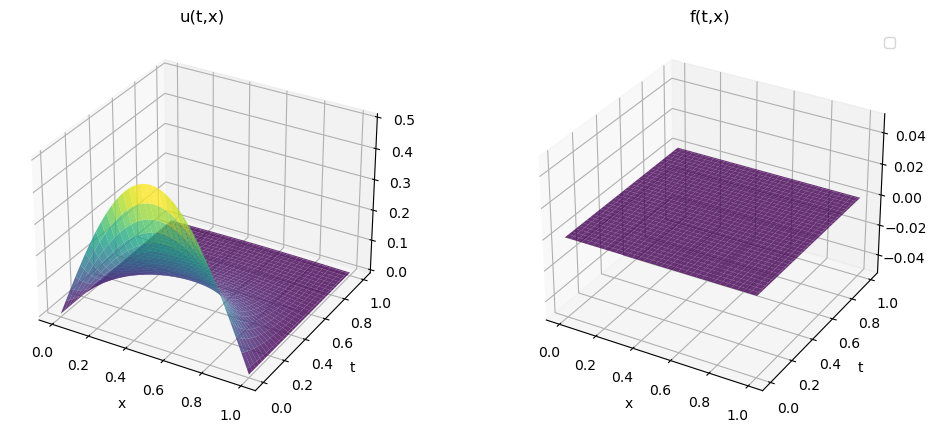

In [3]:
import jax.numpy as jnp
from jax import grad, jit, vmap
import numpy as np
import matplotlib.pyplot as plt
from main_class import PhysicsInformedGP_regressor
from kernels.kernel_heat_equation import k_ff_jax, k_fu_jax, k_uu_jax, k_uf_jax, gram_Matrix_jax
from scipy.optimize import minimize
from joblib import Parallel, delayed
from tqdm import tqdm

kernel_list = [gram_Matrix_jax, k_uu_jax, k_uf_jax, k_fu_jax, k_ff_jax]
#then we define the parameters for the kernel
hyperparameters = ["l_x", "sigma_f","l_t", "alpha"]
#now we can define our model. The model needs the kernel list and the hyperparameters, aswell as the timedependence
model_heat_equation = PhysicsInformedGP_regressor(kernel_list,timedependence=True, params=hyperparameters)
model_heat_equation.set_name_kernel("Wave_equation")
#now we create the training data and a validation set
n_training_points = 20
noise = [1e-8,1e-8]
model_heat_equation.set_training_data("data_files/heat_data.csv ",n_training_points, noise)
model_heat_equation.plot_raw_data()
n_validation_points = 500  #for calculating the MSE
model_heat_equation.set_validation_data(n_validation_points)
X = model_heat_equation.X
Y = model_heat_equation.Y
x_train = model_heat_equation.X[:,0]
t_train = model_heat_equation.X[:,1]
u_train = model_heat_equation.u_train


def k(x1, x2,params):
    x = x1[:, 0][:, jnp.newaxis]
    t = x1[:, 1][:, jnp.newaxis]
    x_ = x2[:, 0][jnp.newaxis, :]
    t_ = x2[:, 1][jnp.newaxis, :]
    denom = 1 + (2 * (t + t_))
    return jnp.exp(-(x - x_) ** 2 / (2 * denom)) / jnp.sqrt(denom)
# @jit
# def k_2(x1, x2, params):
#     x, t = x1[0], x1[1]
#     x_, t_ = x2[0], x2[1]
#     sigma_u = params[0]
#     alpha = params[1]
#     denom = 4*jnp.pi*alpha*(t + t_) 
#     return sigma_u**2/jnp.sqrt(denom) * jnp.exp(-(x -x_)**2/denom)
# k_2 = vmap(vmap(k_2, (None, 0,None)), (0, None,None))
# k = jit(k_2)

def log_marginal_likelohood(params):
    """computes the log marginal likelihood of the GP"""
    K = k(X, Y, params)

    L = jnp.linalg.cholesky(K + 1e-8 * jnp.zeros(K.shape)) #add some jitter for stability

    alpha = jnp.linalg.solve(L.T, jnp.linalg.solve(L, u_train))
    mll = 1/2 * jnp.dot(u_train.T,alpha) +0.5*jnp.sum(jnp.log(jnp.diagonal(L))) + len(X)/2 * jnp.log(2*jnp.pi)
    return jnp.squeeze(mll)


def optimization_restarts_parallel_TNC(self, n_restarts: int, n_threads: int,opt_dictionary: dict) -> dict:
        """
        performs the optimization of the hyperparameters in parallel and returns the best result.
        n_restarts: number of restarts of the optimization
        n_threads: number of threads to use for the parallelization
        opt_dictionary: dictionary containing all the parameters needed for the optimization (initial values, bounds, etc.)
        """
        
        def single_optimization_run():
            """performs a single optimization run with random initialization of the hyperparameters"""
            theta_initial = opt_dictionary['theta_initial']()
            res = minimize(self.log_marginal_likelihood_to_optimize(), x0=theta_initial,
                        method='L-BFGS-B',bounds=opt_dictionary['bounds'],
                        tol = opt_dictionary['gtol'])
            return res
        results = Parallel(n_jobs=n_threads)(delayed(single_optimization_run)() for _ in tqdm(range(n_restarts)))
        #all positive parameters
        results = [res for res in results if  np.all(res.x > 0)]
        
        best_result = min(results, key=lambda x: x.fun)
        print(best_result)
        
        return best_result

def get_initial_values():
    """returns the initial values for the hyperparameters
    for the length scales we initialize them randomly as log(l) ~ U(-1.3,1)
    """
    rng = np.random.default_rng()
    theta_initial = np.zeros((2))
    theta_initial[0] = rng.uniform(0, 2, 1)  #lx
    theta_initial[1] = rng.uniform(0, 1, 1)               #sigma_f            #c
    return theta_initial

n_restarts = 500
n_threads = -1
opt_params_dict = {'theta_initial': get_initial_values,   #needed for all optimization methods
                    'bounds': ((1e-5, None), (1e-5, None)), #needed for TNC and L-BFGS-B
                    'gtol': 1e-6}
#best_result = optimization_restarts_parallel_TNC(model_heat_equation, n_restarts, n_threads, opt_params_dict)



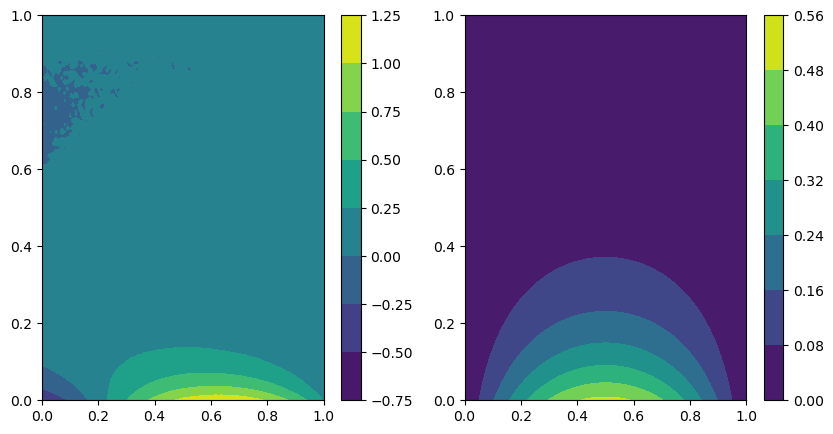

In [4]:
def posterior_mean(X_star,params):
    K = k(X, X,params) + 1e-6 * jnp.eye(len(X))
    K_s = k(X, X_star,params)
    K_ss = k(X_star, X_star,params)
    L = jnp.linalg.cholesky(K)
    alpha = jnp.linalg.solve(L.T, np.linalg.solve(L, u_train))
    f_star = jnp.dot(K_s.T, alpha)
    v = jnp.linalg.solve(L, K_s)
    var_f_star = K_ss - jnp.dot(v.T, v)
    return f_star, var_f_star

n_test_points = 100
x_star, t_star= np.meshgrid(np.linspace(0, 1, n_test_points), np.linspace(0, 1, n_test_points))
X_star = np.hstack((x_star.reshape(-1, 1), t_star.reshape(-1, 1)))
u_pred,var_f_star = posterior_mean(X_star,[])
u_pred = u_pred.reshape(n_test_points, n_test_points)


n_test_points = 100
x_star_raw, t_star_raw = model_heat_equation.raw_data[0].reshape(-1,1), model_heat_equation.raw_data[1].reshape(-1,1)
u_grid = model_heat_equation.raw_data[2]

size = (int(np.sqrt(len(x_star_raw))),int(np.sqrt(len(x_star_raw))))
fig, ax = plt.subplots(1,2,figsize=(10,5))
cont1 = ax[0].contourf(x_star, t_star, u_pred, cmap="viridis")
cont2 = ax[1].contourf(x_star_raw.reshape(size), t_star_raw.reshape(size), u_grid.reshape(size), cmap="viridis")
fig.colorbar(cont1, ax=ax[0])
fig.colorbar(cont2, ax=ax[1])
    
